In [5]:
%load_ext autoreload
%autoreload 2
# perform relevant imports
import Dictionaries
import methods
import System
import utils
import plot_data
import tools

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
numpy.random.seed(2141444)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reproduction work

The aim of this notebook is to reproduce results in the 2020 paper by Korda and Mezic on the optimal construction of eigenfunctions.

### Unforced Van der Pol oscillator

Data is collected using functions in `System.py`. The first differential equation for this work is the unforced Van der Pol oscillator, a chaotic system defined by
$$ \dot x_1 = x_2 $$ 
$$ \dot x_2  = -0.8 x_1 + 2 x_2 - 10 x_1^2 x_2 $$

150 trajectories of this system are initialised, for which 500 time-steps are simulated at a timestep of $dt = 0.01$. Data is stored in `testdata/Korda2020.mat` to speed up execution.

Key 'Generate' not found in system construction
Key 'Autonomous' not found in system construction
Using existing dataset at filepath
100


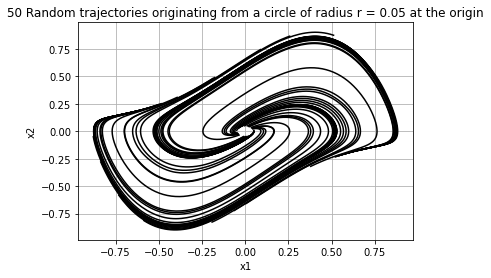

In [14]:
def randomCirc(N, n, r = 0.05):
    '''Construct N initial conditions for random points on an n-d sphere of radius r'''
    # Normalised n-d Gaussian points result in a uniform point on a sphere
    
    random_Initialconditions = np.random.randn(N,n)
    return r * random_Initialconditions / np.linalg.norm(random_Initialconditions, axis=1).reshape((N,1))


KordaEquation = System.differentialEquation(System.forcedvanDerPolSystemKorda, 2, 1)
Korda = System.System(KordaEquation, 'testdata/Korda2020.mat', 500, 150, 0.01, Generate=False, Autonomous=True, Initialisation_function = randomCirc)

X = Korda.trainingData()
plt.plot(Korda.StateSequence[0:50,0,:].T, Korda.StateSequence[0:50,1,:].T, '-k')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("50 Random trajectories originating from a circle of radius r = 0.05 at the origin")
plt.grid()
plt.show()

Then we solve two optimisation problems. First the major linear modes $\lambda_i$ are computed through a subspace algorithm, from which initial conditions of function samples on a nonrecurrent set are computed.
\begin{equation*}
    \min \left\|
    \begin{bmatrix}
        y^1(0) & y^2(0) & \cdots \\ 
        y^1(1) & y^2(1) & \cdots \\ 
        y^1(2) & y^2(2) & \cdots \\ 
        \vdots & \vdots & \ddots %\\ h_i(x^1(N)) \\ h_i(x^2(0)) \\ \vdots
    \end{bmatrix}- 
    \begin{bmatrix}
        1 & 1 & 1 & \cdots \\
        \lambda_1 & \lambda_2 & \lambda_3 & \cdots \\
        \lambda_1^2 & \lambda_2^2 & \lambda_3^2 & \cdots \\
        \vdots & \vdots & \vdots & \ddots
    \end{bmatrix}
    \begin{bmatrix}% End of phantom section for vertical brace alignment
        g_1^1  & g_{1}^2  & \cdots \\ 
        g_{2}^1 & g_{2}^2  & \cdots \\
        \vdots & \vdots & \ddots
    \end{bmatrix} \right\|
\end{equation*}

These initial conditions of functions $g_i$ at initial conditions on $x^j(0) \in \Gamma$ are propagated linearly using the eigenvalues $\lambda_i$ to construct a function surface on the state space. 

In [17]:
N_g = 10
A, f_opt = methods.compute_Korda2020(X, N_g, s = 100, method="Linear")

Computing linear evolution in data to find initial states on nonrecurrent set
Formatting time-delay coordinates with delay s = 100


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Found relative residual in x0 of 10.996 %
Found relative residual in x1 of 35.931 %
(0.441724820907394-7.270980715641709e-17j)
Computed eigenfunction, eigenvalue pairs in 4091.1 ms
Starting computation of linear evolution surface from data


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Computed eigenfunction surface in 10519.8 ms


Lifting dynamics


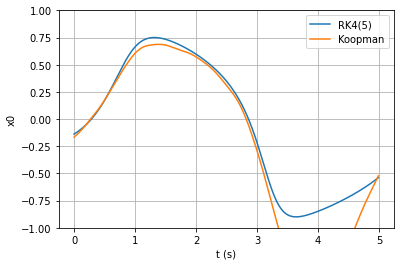

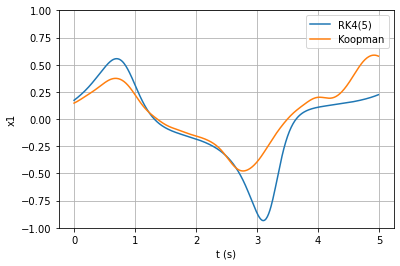

In [19]:
x0 = np.array([-0.1382, 0.1728])
u = np.zeros((1,500))
B = np.zeros((2 * N_g, 1))

t_out, y_est, y_comp = methods.linear_compare(A, B, Korda, f_opt, 0, x0, u)

plot_data.compareTrajectories(t_out, y_comp, y_est.real, Names=["RK4(5)", "Koopman"])

In [39]:
#Compute validation 
vaf, rmse, rrmse = methods.linear_Validate(A, B, Korda, f_opt, 0, maxN=500)

print("Average RRMSE: %.2f +- %.2f" % (numpy.mean(rrmse), numpy.sqrt(numpy.var(rrmse))))
print("Average VAF in x1: %.2f +- %.2f" % (numpy.mean(vaf[0,:]), numpy.sqrt(numpy.var(vaf[0,:]))))
print("Average VAF in x2: %.2f +- %.2f" % (numpy.mean(vaf[1,:]), numpy.sqrt(numpy.var(vaf[1,:]))))

  0%|          | 0/100 [00:00<?, ?it/s]

Average RRMSE: 0.21 +- 0.06
Average VAF in x1: 0.85 +- 0.10
Average VAF in x2: 0.87 +- 0.08
